In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from tensorflow_probability.substrates import jax as tfp
from tqdm import tqdm
from chex import PRNGKey, Array
from typing import Dict, List

from reinforced_lib import RLib
from reinforced_lib.exts import BaseExt, observation, parameter
from reinforced_lib.agents.mab import UCB, EGreedy, Softmax
from reinforced_lib.agents import BaseAgent

tfd = tfp.distributions

In [3]:
def plot_resuls(results_dict: Dict, scatter: bool = True):
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    for agent_name, result in results_dict.items():
        n_steps = len(result['actions'])
        if scatter:
            ax[0].scatter(range(n_steps), result['actions'], label=agent_name, s=1, alpha=0.75)
            ax[1].scatter(range(n_steps), result['rewards'], label=agent_name, s=1, alpha=0.75)
        else:
            ax[0].plot(range(n_steps), result['actions'], label=agent_name)
            ax[1].plot(range(n_steps), result['rewards'], label=agent_name)
    ax[0].set_title('Actions')
    ax[1].set_title('Rewards')
    ax[0].legend()
    ax[1].legend()
    plt.show()

In [11]:
COLORS = {
    "EGreedy": "tab:blue",
    "Softmax": "tab:orange",
    "UCB": "tab:green"
}
AGENTS_TO_PLOT = ["EGreedy", "Softmax", "UCB"]


def smooth(scalars: Array, weight: float) -> Array:  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed

def scatter_actions(results_dict: Dict, smooth_weight: float = 0.0, agents: List = None):
    _, ax = plt.subplots(1, 1, figsize=(10, 4))

    for agent_name, result in results_dict.items():
        if agents is not None and agent_name not in agents:
            continue
        actions = jnp.array(list(map(lambda a: int(a), result['actions'])))
        actions_smooth = smooth(actions, smooth_weight)
        ax.scatter(range(len(actions)), actions, label=agent_name, color=COLORS[agent_name], s=1, alpha=0.4)
        ax.plot(range(len(actions_smooth)), actions_smooth, color=COLORS[agent_name], alpha=0.25, linewidth=2.)
    
    # ax.set_yticks(range(5), list(ACTION_NAMES.values()))
    ax.set_ylabel('Weapon')
    ax.set_xlabel('Steps')
    ax.set_title('Actions')
    ax.legend(loc='lower right')
    plt.show()

def scatter_rewards(results_dict: Dict, smooth_weight: float = 0.0, agents: List = None):
    _, ax = plt.subplots(1, 1, figsize=(10, 4))

    for agent_name, result in results_dict.items():
        if agents is not None and agent_name not in agents:
            continue
        rewards = jnp.array(result['rewards'])
        rewards_smooth = smooth(rewards, smooth_weight)
        ax.scatter(range(len(rewards)), rewards, label=agent_name, color=COLORS[agent_name], s=1, alpha=0.4)
        ax.plot(range(len(rewards_smooth)), rewards_smooth, color=COLORS[agent_name], alpha=0.25, linewidth=2.)
    
    if smooth == 1:
        ax.set_yticks(jnp.unique(jnp.array(result['rewards'])))
    ax.set_ylabel('Reward')
    ax.set_xlabel('Steps')
    ax.set_title('Rewards')
    ax.legend(loc='lower right')
    plt.show()

def plot_cumulative_rewards(results_dict: Dict, smooth_weight: float = 0.0, alpha: float = 0.4, agents: List = None, savepath: str = None):
    _, ax = plt.subplots(1, 1, figsize=(10, 7))

    for agent_name, result in results_dict.items():
        if agents is not None and agent_name not in agents:
            continue
        rewards = jnp.cumsum(jnp.array(result['rewards']))
        rewards_smooth = smooth(rewards, smooth_weight)
        ax.plot(range(len(rewards)), rewards, label=agent_name, color=COLORS[agent_name], alpha=alpha, linewidth=0.5)
        # ax.plot(range(len(rewards_smooth)), rewards_smooth, color=COLORS[agent_name], alpha=0.25, linewidth=2.)
    
    if smooth == 1:
        ax.set_yticks(jnp.unique(jnp.array(result['rewards'])))
    ax.set_ylabel('Cumulative Reward')
    ax.set_xlabel('Steps')
    ax.set_title('Rewards')
    ax.legend(loc='lower right')

    if savepath is not None:
        plt.savefig(savepath, dpi=300, bbox_inches='tight')
        plt.clf()
    else:
        plt.show()

In [5]:
class GUPBExt(BaseExt):
    """
    Reinforced-lib extension for tunnig R2D2s parameters in GUPB.
    This extension can be used with Multi-Armed Bandit (MAB) algorithms.
    """

    def __init__(self, n_arms: int) -> None:
        super().__init__()
        self.n = n_arms

    observation_space = gym.spaces.Dict({})

    @parameter(parameter_type=gym.spaces.Box(1, np.inf, (1,), np.int32))
    def n_arms(self) -> int:
        return self.n

    @observation(observation_type=gym.spaces.Box(-np.inf, np.inf, (1,)))
    def reward(self, reward, *args, **kwargs) -> float:
        return reward

In [6]:
def run_agent(agent: RLib, rewards: Array, n_steps: int, key: PRNGKey):
    
    act = 0
    act_acc = [act]
    reward_acc = [rewards[act].sample(seed=key)]
    for _ in tqdm(range(n_steps)):
        key, subkey = jax.random.split(key)
        act = agent.sample(reward_acc[-1])
        act_acc.append(act)
        reward_acc.append(jnp.clip(rewards[act].sample(seed=subkey), 0.))
    
    return act_acc, reward_acc

In [7]:
rewards = [
    tfd.Normal(loc=i, scale=10.) for i in [2, 4, 12, 23, 41]
]

In [31]:
agents = {
    'EGreedy': RLib(
        agent_type=EGreedy,
        agent_params={'e': 0.166, 'optimistic_start': 1000.0},
        ext_type=GUPBExt,
        ext_params={'n_arms': len(rewards)}
    ),
    'Softmax': RLib(
        agent_type=Softmax,
        agent_params={'lr': 1., 'tau': 50., 'multiplier': 0.01},
        ext_type=GUPBExt,
        ext_params={'n_arms': len(rewards)}
    ),
    'UCB': RLib(
        agent_type=UCB,
        agent_params={'c': 120},
        ext_type=GUPBExt,
        ext_params={'n_arms': len(rewards)}
    )
}

In [32]:
results_dict = {}
n_steps = 2000
for agent_name, agent in agents.items():
    key = jax.random.PRNGKey(2137)
    act_acc, reward_acc = run_agent(agent, rewards, n_steps, key)
    results_dict[agent_name] = {
        "actions": act_acc,
        "rewards": reward_acc
    }

100%|██████████| 2000/2000 [00:01<00:00, 1393.69it/s]


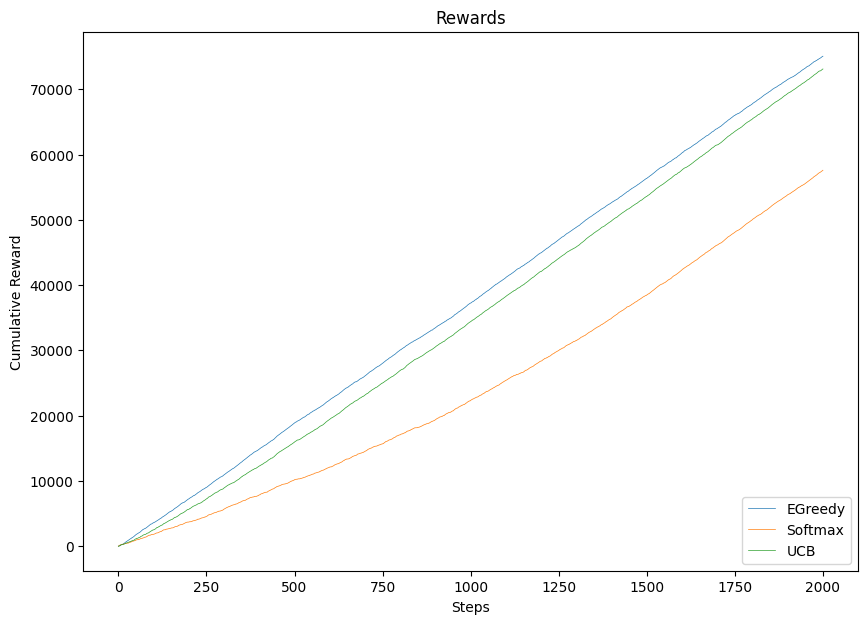

In [33]:
plot_cumulative_rewards(results_dict, smooth_weight=0.0, agents=AGENTS_TO_PLOT, alpha=1.0)

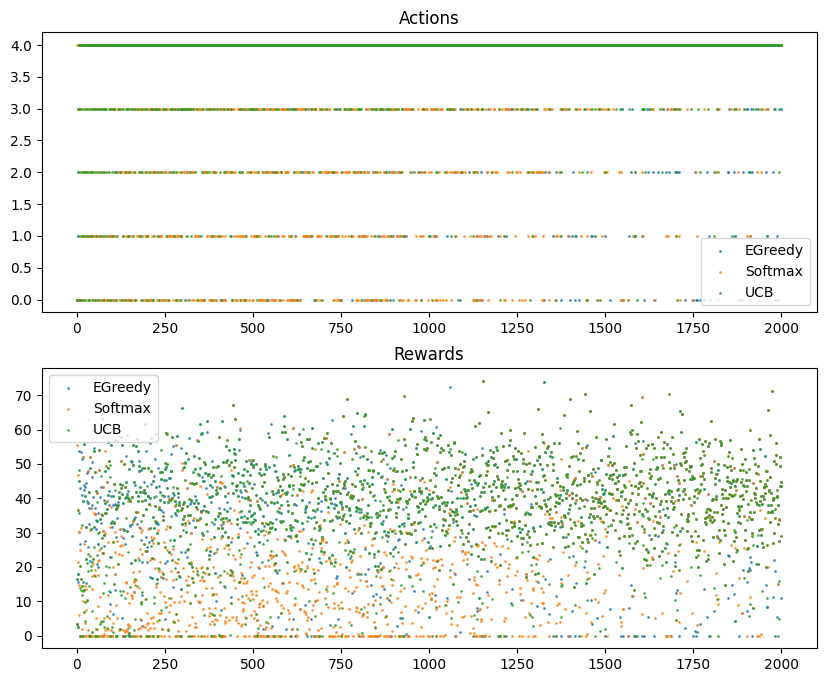

In [34]:
plot_resuls(results_dict)

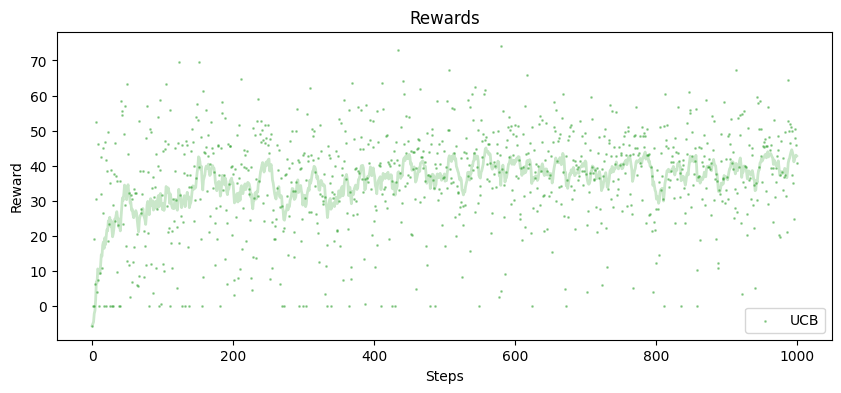

In [37]:
scatter_rewards(results_dict, smooth_weight=0.9)

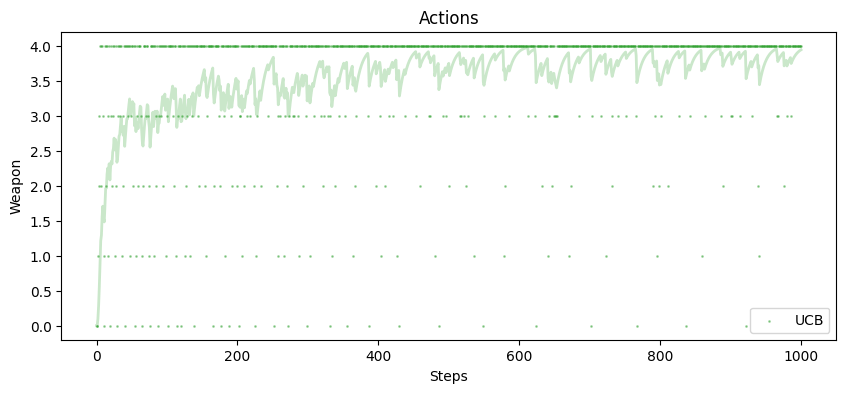

In [38]:
scatter_actions(results_dict, smooth_weight=0.9)

In [32]:
0.9**50

0.00515377520732012